In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import pandas as pd
import geopandas as gpd
import geospatial_utils
from shapely.geometry import box

local_crs = 3106 # Bangladesh crs in metres

wd = os.path.join(os.sep,'Users', 'alison', 'Documents', 'DPhil')
datadir = os.path.join(wd, 'data')
bathypath = os.path.join(datadir, 'gebco', 'bay_of_bengal', 'gebco_2023_n25.0_s10.0_w80.0_e95.0.nc')
windpath = os.path.join(datadir, 'era5', 'wind_data', 'bangladesh_2021.nc')

# Developing code to extract grids from shapefiles and NetCDFs

    # check cell ordering: turn this into some sort of test function later
    centroid = [94, 17.5]
    width, height = 100_000, 200_000

    angles = [91, 1, 181, 271]
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

    for angle, ax in zip(angles, axs.ravel()):
        grid, index = geospatial_utils.create_aoi_grid(centroid, mesh=30_000, height=height, width=width, rotation=angle, local_crs=local_crs)
        grid = gpd.GeoDataFrame({'index': index.tolist()}, geometry=grid).set_crs(local_crs)
        grid['i'] = grid['index'].apply(lambda x: x[0])
        grid['j'] = grid['index'].apply(lambda x: x[1])
        grid.plot('i', ax=ax, legend=True, categorical=True)
        ax.set_title(angle)


    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    for angle, ax in zip(angles, axs.ravel()):
        grid, index = geospatial_utils.create_aoi_grid(centroid, mesh=30_000, height=height, width=width, rotation=angle, local_crs=local_crs)
        grid = gpd.GeoDataFrame({'index': index.tolist()}, geometry=grid).set_crs(local_crs)
        grid['i'] = grid['index'].apply(lambda x: x[0])
        grid['j'] = grid['index'].apply(lambda x: x[1])
        grid.plot('j', ax=ax, legend=True, categorical=True)
        ax.set_title(angle)

<Axes: >

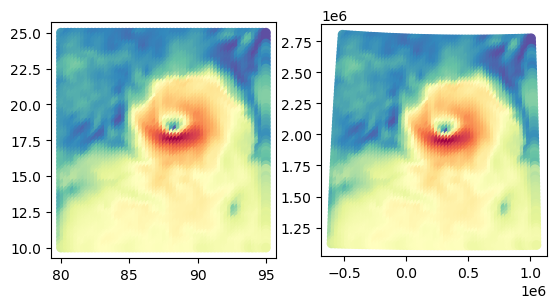

In [2]:
# load dataframe from NetCDF file
df_wind = geospatial_utils.xarray_to_geopandas_with_time(windpath, xvar='longitude', yvar='latitude', var=['u10', 'v10'])
df_wind['time'] = pd.to_datetime(df_wind['time'])
df_wind['speed'] = np.sqrt(df_wind['u10']**2 + df_wind['v10']**2)
df_wind['direction'] = np.arctan(df_wind['v10'] / df_wind['u10']) # East is 0 degrees [radians]

# choose a windy day
idxmax = df_wind['speed'].idxmax()
time = df_wind.loc[idxmax, 'time']
df_wind = df_wind.loc[df_wind['time'] == time, :]
fig, axs = plt.subplots(1, 2)
df_wind.plot('speed', ax=axs[0], cmap='Spectral_r')

# transform to local crs
df_wind = df_wind.to_crs(local_crs)
df_wind.plot('speed', ax=axs[1], cmap='Spectral_r')

<Axes: >

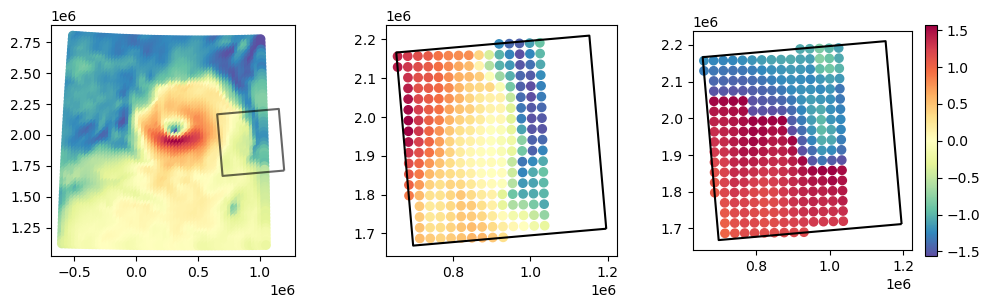

In [3]:
centroid = [94, 17.5]
width, height = 500_000, 500_000
aoi = geospatial_utils.create_aoi(centroid, height, width, rotation=5, local_crs=local_crs)

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
ax = axs[0]
df_wind.plot('speed', ax=ax, cmap='Spectral_r')
aoi.boundary.plot(color='k', ax=ax, alpha=.6, zorder=10)

df_aoi = gpd.overlay(df_wind, aoi, how='intersection')

ax = axs[1]
aoi.boundary.plot(color='k', ax=ax, cmap='Spectral_r')
df_aoi.plot('speed', ax=ax, cmap='Spectral_r')

ax = axs[2]
aoi.boundary.plot(color='k', ax=ax, cmap='Spectral_r')
df_aoi.plot('direction', ax=ax, cmap='Spectral_r', legend=True)

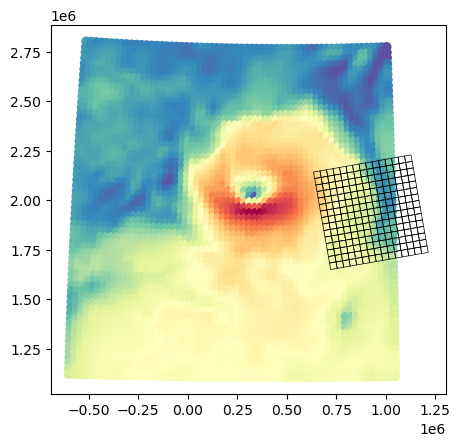

In [4]:
# from shapely.geometry import MultiPolygon
# from shapely.affinity import rotate
# reload(geospatial_utils)
mesh = 50_000
rotation = 10
mesh = 30_000
grid, _ = geospatial_utils.create_aoi_grid(centroid, mesh=mesh, height=height, width=width, rotation=rotation, local_crs=local_crs)

fig, ax = plt.subplots()
df_wind.plot('speed', ax=ax, cmap='Spectral_r')
grid.boundary.plot(color='k', linewidth=.5, ax=ax, zorder=10);

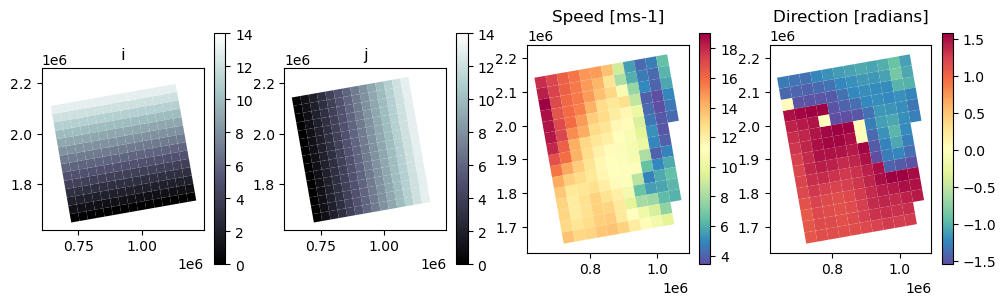

In [14]:
grid, index = geospatial_utils.create_aoi_grid(centroid, mesh=mesh, height=height, width=width, rotation=rotation, local_crs=local_crs)
wind_grid = geospatial_utils.grid_zonal_statistics(grid, index, df_wind, local_crs, ['speed', 'direction'])

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
wind_grid.plot('i', legend=True, ax=axs[0], cmap='bone')
wind_grid.plot('j', legend=True, ax=axs[1], cmap='bone')
wind_grid.plot('speed', legend=True, ax=axs[2], cmap='Spectral_r')
wind_grid.plot('direction', legend=True, ax=axs[3], cmap='Spectral_r')

axs[0].set_title('i')
axs[1].set_title('j');
axs[2].set_title('Speed [ms-1]')
axs[3].set_title('Direction [radians]');

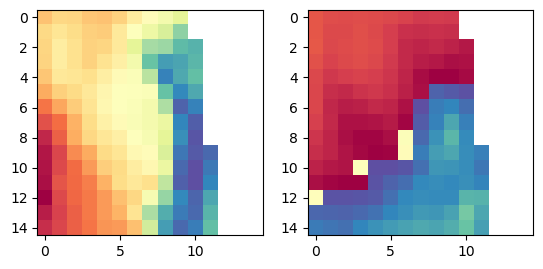

In [15]:
# finally, make it a numpy matrix where (0, 0)->(ny,nx) is causality
speedmat = geospatial_utils.grid_gdf_to_numpy(wind_grid, 'speed')
dirmat = geospatial_utils.grid_gdf_to_numpy(wind_grid, 'direction')

fig, axs = plt.subplots(1, 2)
axs[0].imshow(speedmat, cmap='Spectral_r')
axs[1].imshow(dirmat, cmap='Spectral_r')

# Bathymetry (do the same)

In [29]:
df_bathy = geospatial_utils.xarray_to_geopandas(bathypath, xvar='lon', yvar='lat', var=['elevation'])
df_bathy = df_bathy.to_crs(local_crs)
bathy_grid = geospatial_utils.grid_zonal_statistics(grid, index, df_bathy, local_crs, ['elevation'])

In [30]:
bathy_grid.head()

,i,j,elevation,geometry
0,4.0,0.0,-2438.153320,"POLYGON ((699248.936 1780738.801, 693460.663 1..."
1,3.0,0.0,-2464.399926,"POLYGON ((705037.208 1747911.876, 699248.936 1..."
2,3.0,1.0,-2500.056101,"POLYGON ((737864.133 1753700.148, 732075.861 1..."
3,3.0,2.0,-2560.428148,"POLYGON ((770691.058 1759488.421, 764902.786 1..."
4,2.0,1.0,-2560.697588,"POLYGON ((743652.406 1720873.223, 737864.133 1..."


<Axes: >

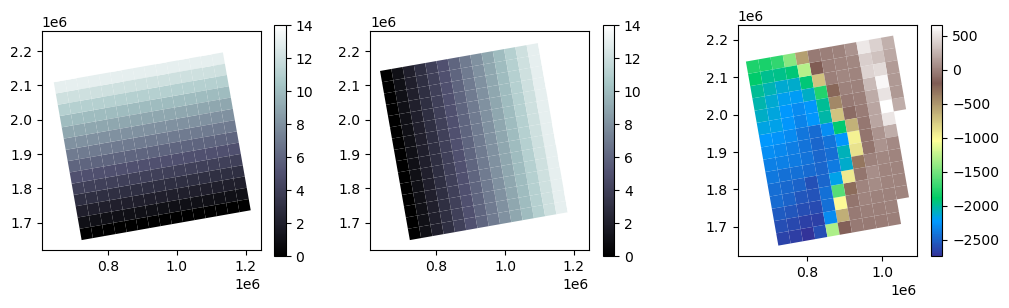

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
bathy_grid.plot('i', legend=True, ax=axs[0], cmap='bone')
bathy_grid.plot('j', legend=True, ax=axs[1], cmap='bone')
bathy_grid.plot('elevation', legend=True, ax=axs[2], cmap='terrain')

# axs[0].set_title('i')
# axs[1].set_title('j');
# axs[2].set_title('Speed [ms-1]')
# axs[3].set_title('Direction [radians]');

In [22]:
ds

<xarray.Dataset>
Dimensions:    (lat: 3600, lon: 3600)
Coordinates:
  * lat        (lat) float64 10.0 10.01 10.01 10.01 ... 24.99 24.99 24.99 25.0
  * lon        (lon) float64 80.0 80.01 80.01 80.01 ... 94.99 94.99 94.99 95.0
Data variables:
    elevation  (lat, lon) int16 -6 -6 -6 -6 -7 -7 -7 ... 162 158 149 129 124 129
Attributes: (12/36)
    title:                           The GEBCO_2023 Grid - a continuous terra...
    summary:                         The GEBCO_2023 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  1.0
    geospatial_vertical_positive:    up
    identifier_product_doi:          DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    references:                      DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    node_offset:                     1.0

NameError: name 'analysis_utils' is not defined

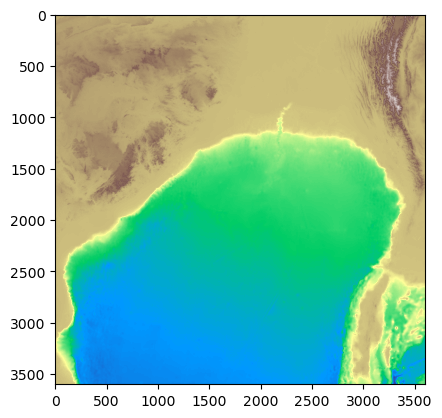

In [18]:
# load bathymetry (remember numpy conversion flips latitude)
ds = xr.open_dataset(bathypath)
bathyarr = ds['elevation'].to_numpy()[::-1,:]
plt.imshow(bathyarr, cmap='terrain')

bathy_gdf = analysis_utils.xarray_to_geopandas(bathypath, var='elevation')
bathy_gdf.head()

In [5]:
ds

<xarray.Dataset>
Dimensions:    (lat: 3600, lon: 3600)
Coordinates:
  * lat        (lat) float64 10.0 10.01 10.01 10.01 ... 24.99 24.99 24.99 25.0
  * lon        (lon) float64 80.0 80.01 80.01 80.01 ... 94.99 94.99 94.99 95.0
Data variables:
    elevation  (lat, lon) int16 ...
Attributes: (12/36)
    title:                           The GEBCO_2023 Grid - a continuous terra...
    summary:                         The GEBCO_2023 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  1.0
    geospatial_vertical_positive:    up
    identifier_product_doi:          DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    references:                      DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    node_offset:                     1.0